# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKModel import HANKModelClass

# Setup

In [2]:
model = HANKModelClass(name='baseline')

# Steady state

In [3]:
model.find_ss(do_print=True)

household problem in ss solved in 8.5 secs [1514 iterations]
household problem in ss simulated in 3.1 secs [2253 iterations]

Implied K = 12.509
Implied Y =  1.562
Implied Z =  0.629
Implied K/Y =  8.006
Implied delta =  0.035
Discrepance in C-C_hh =   0.00000009


In [4]:
par = model.par
sol = model.sol
sim = model.sim
ss = model.ss

In [5]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.2 secs [1514 iterations]
household problem in ss simulated in 0.2 secs [2253 iterations]


**Productivity states:**

In [6]:
for z,pr_z in zip(par.z_grid_ss,par.z_ergodic_ss):
    print(f'Pr[z = {z:.4f}] = {pr_z:.4f}')
    
print('')

ss_mean_z = np.sum(par.z_grid_ss*par.z_ergodic_ss)
ss_mean_log_z = np.sum(np.log(par.z_grid_ss)*par.z_ergodic_ss)
print(f'mean(e): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)
    
ss_std_z = np.sqrt(np.sum(par.z_ergodic_ss*(par.z_grid_ss-ss_mean_z)**2))
print(f'std(e): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(par.z_ergodic_ss*(np.log(par.z_grid_ss)-ss_mean_log_z)**2))
print(f'std(log(e)): {ss_std_z:.3f}')

Pr[z = 0.4585] = 0.0156
Pr[z = 0.5858] = 0.0937
Pr[z = 0.7484] = 0.2344
Pr[z = 0.9561] = 0.3125
Pr[z = 1.2215] = 0.2344
Pr[z = 1.5605] = 0.0938
Pr[z = 1.9936] = 0.0156

mean(e): 1.000
std(e): 0.304
std(log(e)): 0.300


## Policy functions

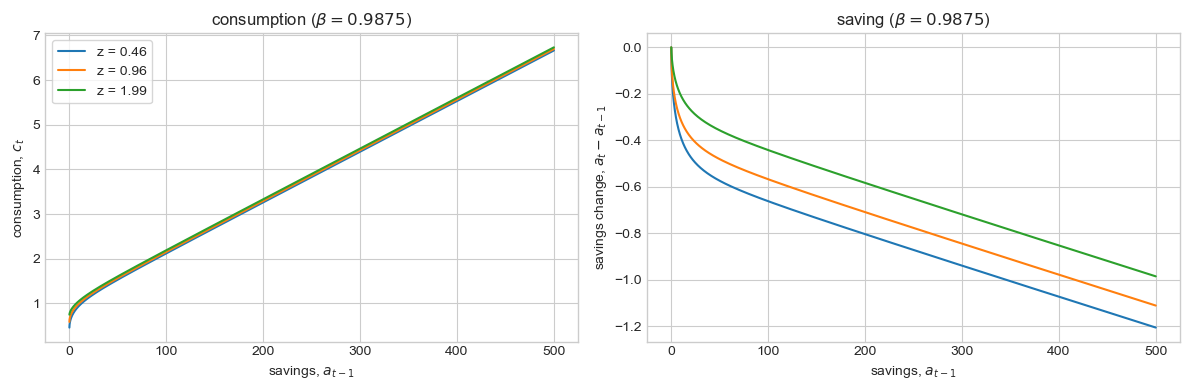

In [7]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid_ss[::3]):
        ax.plot(par.a_grid[I],sol.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid_ss[::3]):
        ax.plot(par.a_grid[I],sol.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

    fig.tight_layout()

## Simulation

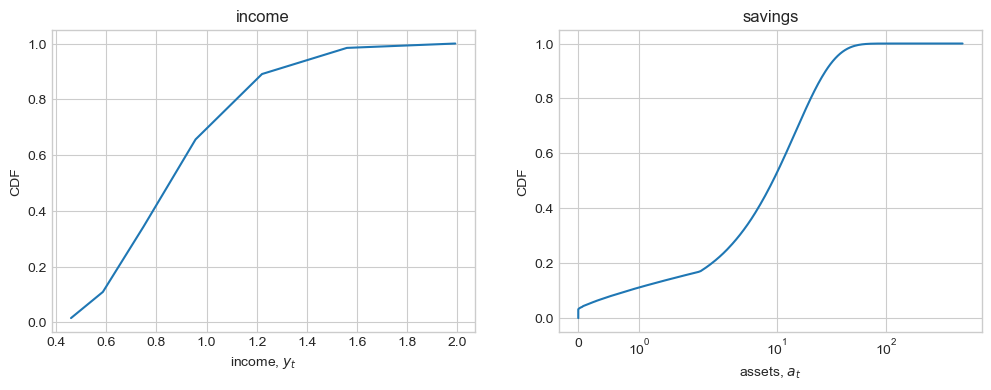

In [8]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('income')
ax.plot(par.z_grid_ss,np.cumsum(np.sum(sim.D,axis=(0,2))))

ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(sim.D,axis=(0,1))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

**Income moments:**

In [9]:
mean_z = np.sum(sim.D*par.z_grid_ss[:,np.newaxis])
std_z = np.sqrt(np.sum(sim.D*(par.z_grid_ss[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.30


**Asset moments:**

In [10]:
# a. prepare
Da = np.sum(sim.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a: 12.509
p25  a:  3.545
p50  a:  9.274
p95  a: 35.143
p99  a: 50.170
std. a: 11.620


**MPC:**

In [11]:
MPC = np.zeros(sim.D.shape)
MPC[:,:,:-1] = (sol.c[:,:,1:]-sol.c[:,:,:-1])/( (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1])
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*sim.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

mean MPC: 0.044 [annual: 0.164]


# Jacobian of household problem at steady state

In [12]:
model.compute_jac_hh(do_print=True)

shockname = __ghost: household Jacobian computed in 6.5 secs
shockname = r: household Jacobian computed in 0.5 secs
shockname = w: household Jacobian computed in 0.5 secs


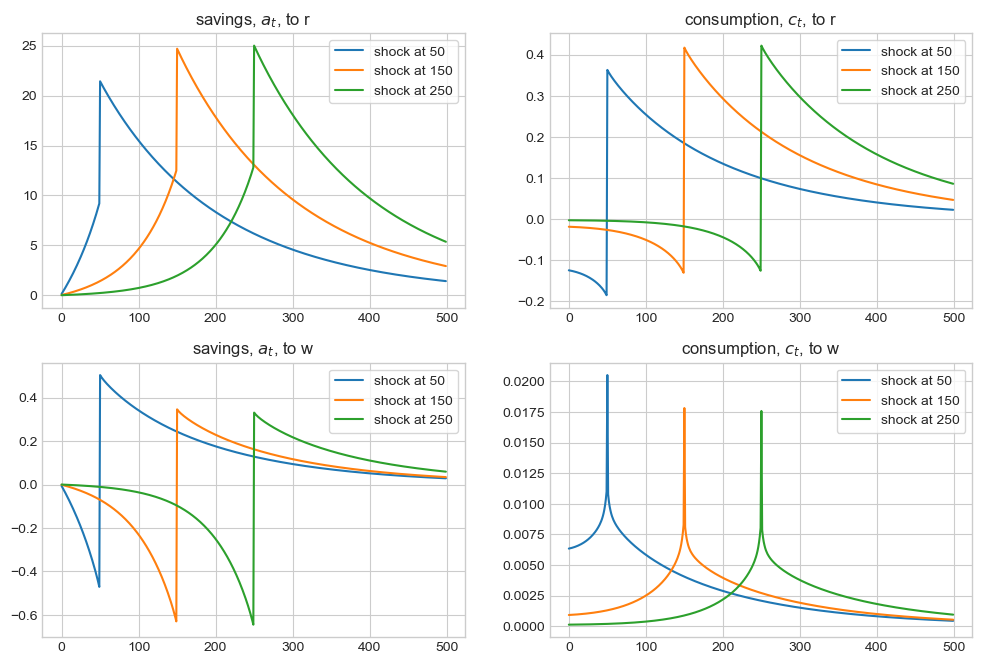

In [13]:
fig = plt.figure(figsize=(12,len(model.inputs_hh)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [50,150,250]:
        jac_hh_var = getattr(model.jac_hh,f'A_{varname}')
        ax.plot(np.arange(par.transition_T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [50,150,250]:
        jac_hh_var = getattr(model.jac_hh,f'C_{varname}')
        ax.plot(np.arange(par.transition_T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)
    

# Transition path

## Find transition path

**Compute full Jacobian at steady state:**

In [14]:
model.compute_jac(do_print=True)

full Jacobian computed in 9.5 secs


In [15]:
model.compute_jac(do_print=True)

full Jacobian computed in 0.2 secs


**Find transition paths:**

In [16]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error =   0.06639445
 it =   1 -> max. abs. error =   0.00006188
 it =   2 -> max. abs. error =   0.00000013
 it =   3 -> max. abs. error =   0.00000000

clearing_A =   0.00000000

max abs. error:   0.00000000

transition path found in 0.8 secs


## Plot transitions

### input, exogenous ###


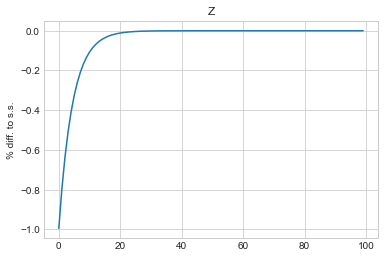


### paths ###


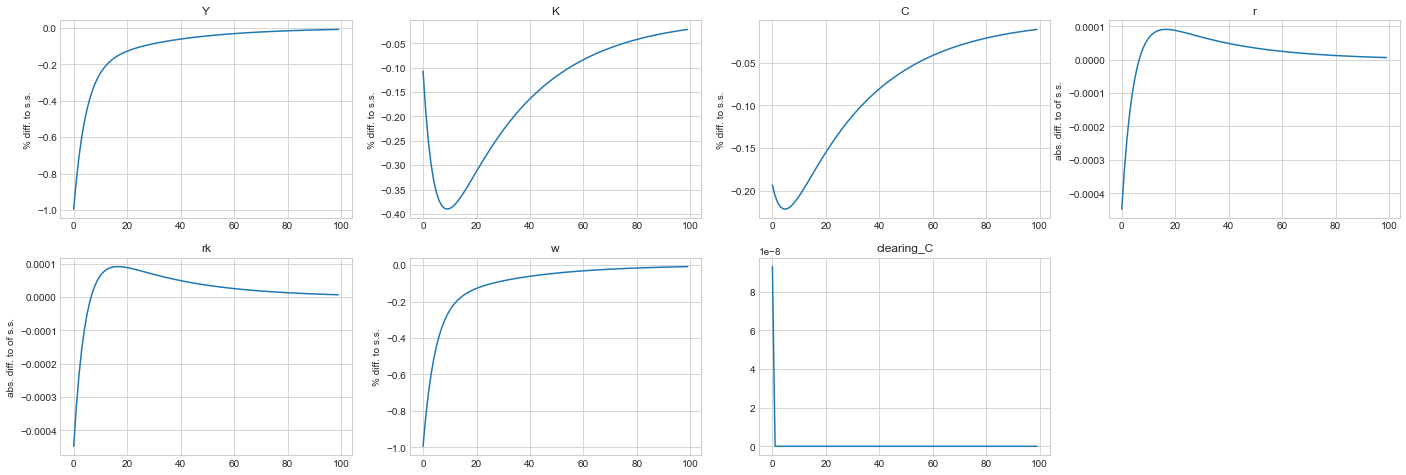


### tagets ###


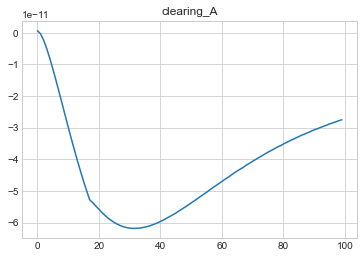

In [17]:
paths = ['Y','K','C','r','rk','w','clearing_C']
abs_value = ['r','rk','clearing_C']
model.show_IRFs(paths,abs_value,T_max=100)

## Check determinancy

In [18]:
model.check_determinancy()

winding_number = 0
up_passing = 100
down_passing = 100
